<a href="https://colab.research.google.com/github/AlanMarquesRocha/t04_ica_final_project/blob/master/t04_ica_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Programa de Pós-Graduação em Engenharia Elétrica e de Computação (PPGEEC)**
### **Inteligência Computacional Aplicada (ICA)**
### **Trabalho Final**
### Classificação de defeitos em células fotovoltaicas de silício monocristalino baseado em extração de características de textura por meio do LBP
### **Discente: Alan Marques da Rocha**


# **PARTE I: Extração de características de textura aplicando-se a técnica Padrão Binário Local (do inglês, ``LOCAL BINARY PATTERN`` (LBP))**

### **1ª Etapa: Importação das bibliotecas necessárias para a extração de características de texturas baseada em LBP (``Local Binary Pattern``)**

In [1]:
import cv2
from skimage.color import rgb2gray
from PIL import Image

# importação da lib do método LBP
from skimage.feature import local_binary_pattern

### **2ª Etapa: Importação das bibliotecas necessárias para implementação da Rede Neural Convolucional (CNN)**

In [2]:
# Libraries that will import classes, functions and methods from CNN
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# to show the proposed model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tf.__version__

'2.9.2'

### **3ª Etapa: Importação das libs para acesso a pastas do drive, manipulação dos dados e plotagem de gráficos**

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Importação de libs para acesso a repositórios
import glob
from skimage import io

# for generation and random values
import random

# lib de validação cruzada com Stratified K-fold
from sklearn.model_selection import StratifiedKFold

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **4ª Etapa: Copiando as imagens para um diretório de acesso do colab**

In [4]:
# Realiza a cópia de uma pasta específica do drive no ambiente colab:
# O comando abaixo realiza uma cópia das imagens que serão utilizadas no projeto.

# cópia as imagens do dataset para uma pasta específica do drive
!cp -R /content/gdrive/MyDrive/_ppgeec_mestrado/2022_2/_disciplinas_semestrais/inteligencia_computacional_aplicada/trabalhos/trabalho_final/dataset/mono dataset/

### **5ª Etapa: Carregando as imagens do ``dataset``**

#### **5.1: Carregando as imagens e convertendo em Níveis de cinza**

In [5]:
# Pega a lista de todas as imagens no diretório [dataset]
paths = glob.glob("/content/dataset/*.png")

imgs_gray = [] # cria uma lista vazia para armazenar as imagens em níveis de cinza.

# importa as imagens, converte para níveis de cinza e armaneza na lista imgs_gray.
for path in paths:
    imgs_gray.append(rgb2gray(io.imread(path)))


<ipython-input-5-cdd8b44f126f>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  imgs_gray.append(rgb2gray(io.imread(path)))


In [8]:
# Carregando as labels das imagens do dataset
labels = pd.read_csv('/content/gdrive/MyDrive/_ppgeec_mestrado/2022_2/_disciplinas_semestrais/inteligencia_computacional_aplicada/trabalhos/trabalho_final/dataset/labels.csv', sep=';')

labels.head(10)

,imagem,prob_defect,type_cell
0,mono/cell0001.png,1.0,mono
1,mono/cell0002.png,1.0,mono
2,mono/cell0003.png,1.0,mono
3,mono/cell0004.png,0.0,mono
4,mono/cell0005.png,1.0,mono
5,mono/cell0006.png,1.0,mono
6,mono/cell0007.png,1.0,mono
7,mono/cell0008.png,1.0,mono
8,mono/cell0009.png,0.0,mono
9,mono/cell0010.png,1.0,mono


#### **5.2 Informações sobre o dataset**

O conjunto de dados possui duas classes, a saber: 

- Funcionais: 0.0
- Defeituosas: 1.0

A divisão do conjunto de dados é apresentado a seguir:

In [10]:
# Apresentando a quantidade de células defeituosas (classe 0.0) e funcionais (classe 1.0)
labels['prob_defect'].value_counts()

0.0    588
1.0    486
Name: prob_defect, dtype: int64

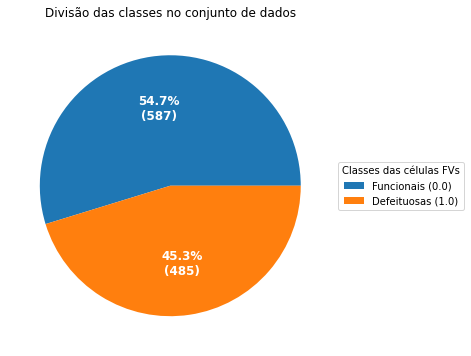

In [11]:
# Area that plots the graph and defines its size
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

# Class information
recipe = ['Funcionais (0.0)', 'Defeituosas (1.0)']

# The amount of data is reported
data_class = [588, 486]

# Shows the percentage of each class in the dataset
def func(pct, allvals):
    # calc %
    absolute = int(pct/100.*np.sum(allvals))
    # fazendo legenda do gráfico
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the chart and placing the inner legend function
wedges, texts, autotexts = ax.pie(data_class, autopct = lambda pct: func(pct, data_class),
                                  textprops=dict(color = "w"))

# Defining the external caption box, title, location and where to 'anchor the box'
ax.legend(wedges, recipe,
          title="Classes das células FVs",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Here we set the text size from within the graphic, and the font weight to bold
plt.setp(autotexts, size=12, weight="bold")

# chart title
ax.set_title("Divisão das classes no conjunto de dados")

# showing the chart
plt.show()

#### **5.3: Mostrando alguns exemplos de imagens**

A seguir serão mostrados alguns exemplos de imagens de células fotovoltaicas de silício monocristralino em níveis de cinza.

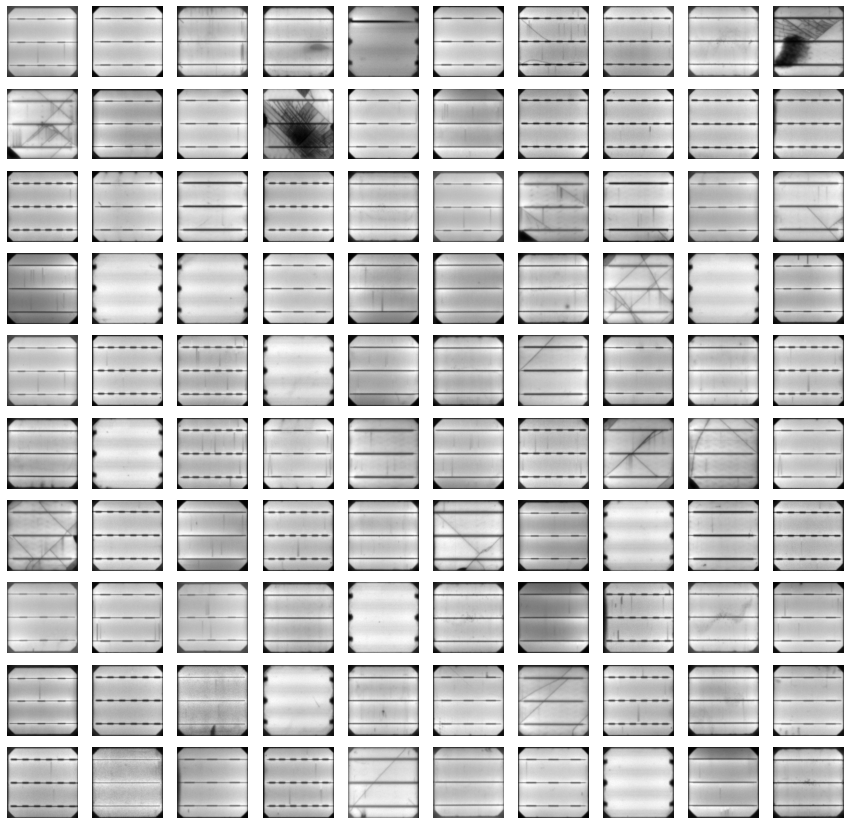

In [12]:
L_grid = 10 # Especifica o número de linhas
W_grid = 10 # Especifica o número de colunas

k = 0.2
fig, axes = plt.subplots(L_grid, W_grid, figsize = (15,15))
axes = axes.ravel()
n_images = len(imgs_gray)

for i in np.arange(0, W_grid * L_grid):
  #index = np.random.randint(0, n_images)
  axes[i].imshow(imgs_gray[i], cmap = 'gray')
  # axes[i].set_title(labels, fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

### **6ª Etapa: Pré-Processamento das Imagens**


#### **6.1 Fitragem das imagens do dataset**

Nessa etapa será realizado a aplicação do **``Filtro Gaussiano Bilateral``** através de uma função da biblioteca OpenCV.

Um filtro bilateral é um filtro de preservação de borda e redução de ruído. Ele calcula a média de pixels com base em sua proximidade espacial e similaridade radiométrica. [Fonte](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html)

Os principais atributos da função ``cv2.bilateralFilter( )`` são apresentadas a seguir:

``cv2.bilateralFilter``	(<br>
``InputArray``: Fonte de imagem de 8 bits ou ponto flutuante, 1 canal ou 3 canais. <br>
d: Diâmetro de cada vizinhança de pixel que é usado durante a filtragem <br> 
)		

In [13]:
# Cria uma lista para guardar as imagens filtradas
imgs_filter = []

# Realiza o processo de filtragem papra cada imagem dentro da lista imgs_gray
for img in imgs_gray:
  # aplicando o filtro bilateral com uma distancia d = 30
  imgs_filter.append(cv2.bilateralFilter(img, 30, 15, 15))

#### **6.2 Mostrando alguns exemplos do resultado obtido**

A seguir serão mostrados alguns exemplos de imagens de células fotovoltaicas de silício monocristralino com aplicação do filtro Gaussiano bilateral

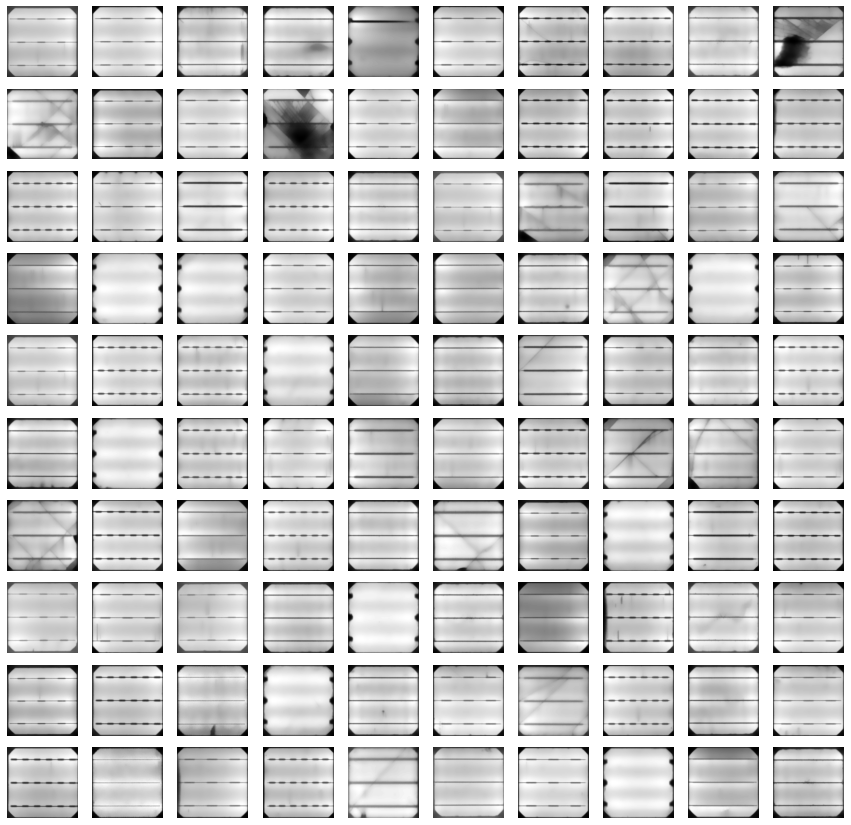

In [14]:
L_grid = 10 # Especifica o número de linhas
W_grid = 10 # Especifica o número de colunas

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15,15))
axes = axes.ravel()
n_images = len(imgs_filter)

for i in np.arange(0, W_grid * L_grid):
  #index = np.random.randint(0, n_images)
  axes[i].imshow(imgs_filter[i], cmap = 'gray')
  # axes[i].set_title(labels, fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

### **7ª Etapa: Aplicação do Método Local Binary Pattern (LBP) para extração de características de textura.**

In [15]:
# tipo de LBP
METHOD = 'uniform'  
radius = 1  # distância entre o pixel central e a comparação dos pixels
n_points = 8 * radius  # define o número de comparações dos pixels

# cria uma lista para armazenar as características de textura das imagens
imgs_lbp = []

# Cria o LBP para cada imagem filtrada na etapa 6.1 que encontra-se armazenada na lista imgs_filter = []
for img in imgs_filter:
  imgs_lbp.append(local_binary_pattern(img, n_points, radius, METHOD))

#### **7.1: Mostrando alguns exemplos do resultado obtido**

A seguir serão mostrados alguns exemplos de imagens de células fotovoltaicas de silício monocristralino com aplicação do LBP.

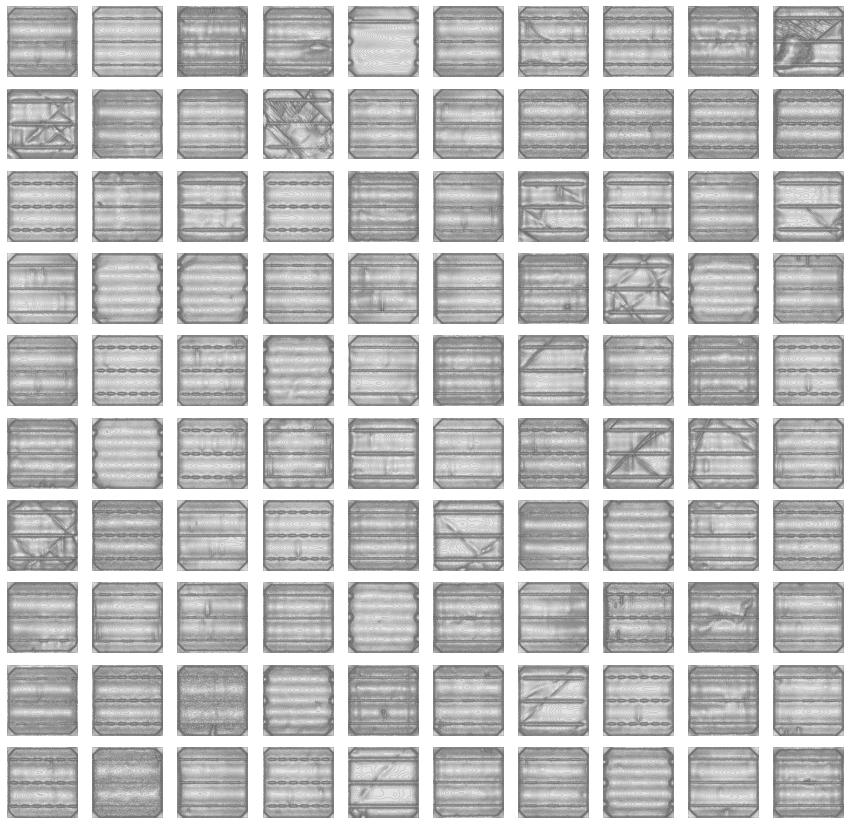

In [16]:
L_grid = 10 # Especifica o número de linhas
W_grid = 10 # Especifica o número de colunas

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15,15))
axes = axes.ravel()
n_images = len(imgs_lbp)

for i in np.arange(0, W_grid * L_grid):
  #index = np.random.randint(0, n_images)
  axes[i].imshow(imgs_lbp[i], cmap = 'gray')
  # axes[i].set_title(labels, fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

# **PARTE II: Implementação da ``Rede Neural Convolucional`` (CNN) para classificação de defeitos em células de módulos FVs de silício monocristalino**

### **8ª Etapa: Normalização dos dados e Validação Cruzada com ``Stratified K-fold``**

#### **8.1: Importação do conjunto de treino e teste**

A seguir serão importados os conjuntos de treino e validação após a extração de atributos por meio do LBP.

In [32]:

# Importando a base de treino após aplicação da LBP
imgs_cell_train = pd.read_csv('/content/gdrive/MyDrive/_ppgeec_mestrado/2022_2/_disciplinas_semestrais/inteligencia_computacional_aplicada/trabalhos/trabalho_final/dataset/imgs_cell_fv_train.csv', sep = ';')

# Importando a base de teste após a aplicação da LBP
imgs_cell_test = pd.read_csv('/content/gdrive/MyDrive/_ppgeec_mestrado/2022_2/_disciplinas_semestrais/inteligencia_computacional_aplicada/trabalhos/trabalho_final/dataset/imgs_cell_fv_test.csv', sep = ';')


In [33]:
# Mostrando alguns exemplos das imagens representadas pelos pixels
imgs_cell_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,164,177,163,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,40,...,125,93,87,49,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
# Convertendo os valores dos pixels dos conjuntos de treino e teste em valores de ponto flutuante
training = np.array(imgs_cell_train, dtype = 'float32')

testing = np.array(imgs_cell_test, dtype = 'float32')

In [35]:
# Mostra os valores dos pixels convertidos em ponto flutuante
training

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### **8.2 Normalização dos dados**

Aqui será realizado a normalização dos dados das imagens, representando-as entre 0.0 e 1.0

In [36]:
# Training set normalization
conv_train = training[:, 1:] / 255

# Test set normalization
conv_test = testing[:, 1:] / 255


In [37]:
# Apresentando a matriz representativa de uma imagem com seus pixels normalizados:
conv_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### **8.3 Definindo o conjunto de treino e teste da rede CNN** 

In [38]:
# Training set:
X_train = conv_train
y_train = training[:, 0]

# Test set:
X_test = conv_test
y_test = testing[:, 0]

In [1]:
X_train = X_train.reshape(X_train.shape[0], * (300, 300, 1))

X_test = X_test.reshape(X_test.shape[0], * (300,300, 1))

### **9ª Etapa: Construção do modelo proposto da CNN**

O modelo ``Sequential()`` disponibiliza ferramentas de inferência e treinamento para CNNs

As camadas de ``convolução`` e ``pooling`` são adicionadas usado o método ``add``

Quatro métodos foram utilizados para a construção da CNN, a saber: ``layers.Conv2D``, ``layers.MaxPooling2D``, ``layers.Flatten`` and ``layers.Dense``. 

Os principais atributos de cada método são apresentados a seguir:

#### **9.1 Características dos métodos utilizados**

**``tf.keras.layers.Conv2D``**(<br>
    ``filters``: Determines the number of output filters in the convolution).<br>
    ``kernel_size``: Specifies the height and width of the 2D convolution window; <br>
    ``strides``: Specifies the convolution steps along the height and width;<br>
    ``padding``: Complements the filling of the image, in case the stride exceeds the dimensions;<br>
    ``activation``: Activation function to use. <br>

Types of activation functions can be checked [here.](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

---

**``tf.keras.layers.MaxPool2D``**(<br>
    ``pool_size``: Size of the analysis window for pixels, returning the maximum value;<br>
    ``strides``: Step values. Specifies how far the nesting window moves for each nesting step;<br>
    ``padding``: Complements the padding of the image, in case the stride exceeds the dimensions. <br>

---

**``tf.keras.layers.Flatten( )``**: Does not receive any parameter. It is responsible for converting the feature matrix of the last layer of CNN to a vector that will be applied in the input layer of the classifier.

---

**``tf.keras.layers.Dense``**(<br>
    ``units``: Positive integer, output space dimensionality.<br>
    ``activation``: Activation function to be used (Ex: ``softmax``)

  ---

### **9.2 Implementação do modelo da CNN**

- 2 x CONV2D
- 2 x MaxPooling2D 
- 1 x Flatten
- 3 x Dense

In [40]:
# number of filters for each convolution layer (filters)
c_entrada = [64, 32]

# number of neurons in fully connected layers:
c_dense = [120, 120, 2]

# defining the kernel:
kernel = (3, 3)

# convolution steps (stride)
strd = 1

# defining the activation function of the convolution layers:
act_func = 'relu'

# setting the cnn classifier activation function
act_func_class = 'softmax'

# starting the model
model_cnn = models.Sequential()


# 1st CNN convolution layer
model_cnn.add(layers.Conv2D(c_entrada[0], kernel, strd, activation = act_func, input_shape=(300, 300, 1)))
# 1st CNN Pooling layer (maximum pooling applies)
model_cnn.add(layers.MaxPooling2D((2,2), padding = 'same'))


# 2st CNN convolution layer
model_cnn.add(layers.Conv2D(c_entrada[1], kernel, strd, activation = act_func))
# 2st CNN Pooling layer (maximum pooling applies)
model_cnn.add(layers.MaxPooling2D((2,2), padding = 'same'))


# Conversion of attribute matrix to attribute vector
model_cnn.add(layers.Flatten())


# 1st layer fully connected:
model_cnn.add(layers.Dense(c_dense[0], activation = act_func))
# 2st layer fully connected:
model_cnn.add(layers.Dense(c_dense[1], activation = act_func))

# Last layer of classifier with softmax activation function.
model_cnn.add(layers.Dense(c_dense[2], activation = act_func_class))

In [ ]:
# Apresenta o sumário das camadas da CNN
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 298, 298, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 175232)            0         
                                                                 
 dense_9 (Dense)             (None, 120)              

### **10ª Etapa: Treinamento, Teste e Validação do Modelo Proposto:**

In [41]:
# definindo o tipo de otimizador e métrica para verificar a assertividade do modelo.
model_cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam',
            metrics = ['accuracy'])

In [42]:
# definindo o número de épocas
epochs = 50

# showing the network training loss and accuracy at each epoch
history = model_cnn.fit(X_train, y_train, batch_size = 10, epochs = epochs)

Epoch 1/50
86/86 [==============================] - 2s 18ms/step - loss: 0.3978 - accuracy: 0.8628
Epoch 2/50
86/86 [==============================] - 1s 17ms/step - loss: 0.3332 - accuracy: 0.9000
Epoch 3/50
86/86 [==============================] - 2s 18ms/step - loss: 0.3336 - accuracy: 0.9070
Epoch 4/50
86/86 [==============================] - 2s 17ms/step - loss: 0.3138 - accuracy: 0.9081
Epoch 5/50
86/86 [==============================] - 1s 17ms/step - loss: 0.3073 - accuracy: 0.9070
Epoch 6/50
86/86 [==============================] - 1s 17ms/step - loss: 0.2967 - accuracy: 0.9128
Epoch 7/50
86/86 [==============================] - 1s 17ms/step - loss: 0.2870 - accuracy: 0.9151
Epoch 8/50
86/86 [==============================] - 1s 17ms/step - loss: 0.2801 - accuracy: 0.9163
Epoch 9/50
86/86 [==============================] - 1s 17ms/step - loss: 0.2549 - accuracy: 0.9221
Epoch 10/50
86/86 [==============================] - 1s 17ms/step - loss: 0.2475 - accuracy: 0.9151
Epoch 11/

In [44]:
# Apresenta a acurácia do conjunto de validação do modelo proposto
test_loss, evaluation = model_cnn.evaluate(X_test, y_test, verbose = 2);


print('\nAcurácia do teste atual: ', evaluation);

7/7 - 0s - loss: 1.1777 - accuracy: 0.8796 - 88ms/epoch - 13ms/step

Acurácia do teste atual:  0.8796296119689941


### **11ª Etapa: Apresentação da Matriz de Confusão (MC) das classificações preditas.**

7/7 [==============================] - 0s 12ms/step


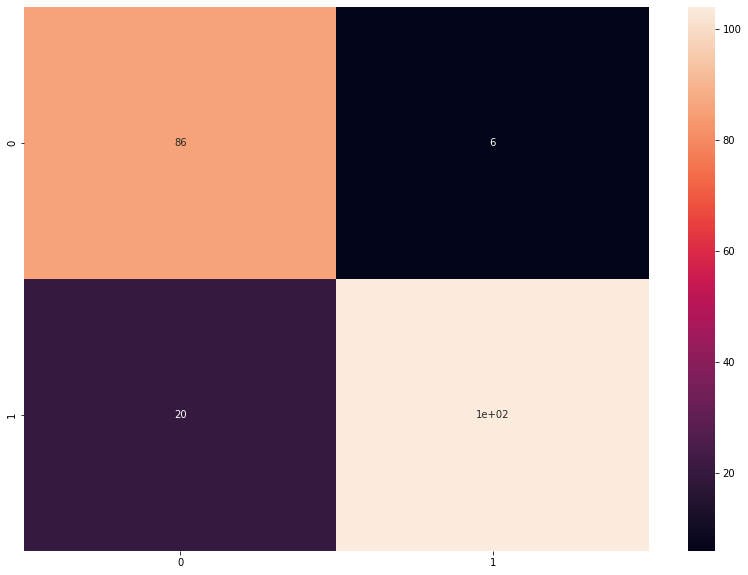

In [45]:
predict_x = model_cnn.predict(X_test) 
predicted_classes = np.argmax(predict_x, axis = 1)

cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (14,10));
sns.heatmap(cm, annot=True)

In [46]:
# apresentando a Matriz de Confusão em sua forma tabular
cm

array([[ 86,   6],
       [ 20, 104]])

In [48]:

# Mostra a acurácia, recall e f1-score para cada classe do conjunto de teste
num_classes = 2
target_names = ["Class {}".format(i) for i in range(num_classes)]
target_names;

print(classification_report(y_test, predicted_classes, target_names=target_names))
     

              precision    recall  f1-score   support

     Class 0       0.81      0.93      0.87        92
     Class 1       0.95      0.84      0.89       124

    accuracy                           0.88       216
   macro avg       0.88      0.89      0.88       216
weighted avg       0.89      0.88      0.88       216

